In [1]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# changed configuration to this instead of argparse for easier interaction
CUDA = True
SEED = 1
BATCH_SIZE = 32
LOG_INTERVAL = 10
EPOCHS = 2000

In [3]:
# connections through the autoencoder bottleneck
# in the pytorch VAE example, this is 20
# ZDIMS = 20

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

# DataLoader instances will load tensors directly into GPU memory
kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}

In [4]:
transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.ToTensor(),
                                # transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                # std=(0.5, 0.5, 0.5))
                               ]
)

dataset = datasets.ImageFolder(root='/content/Cars', transform=transform)
data_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

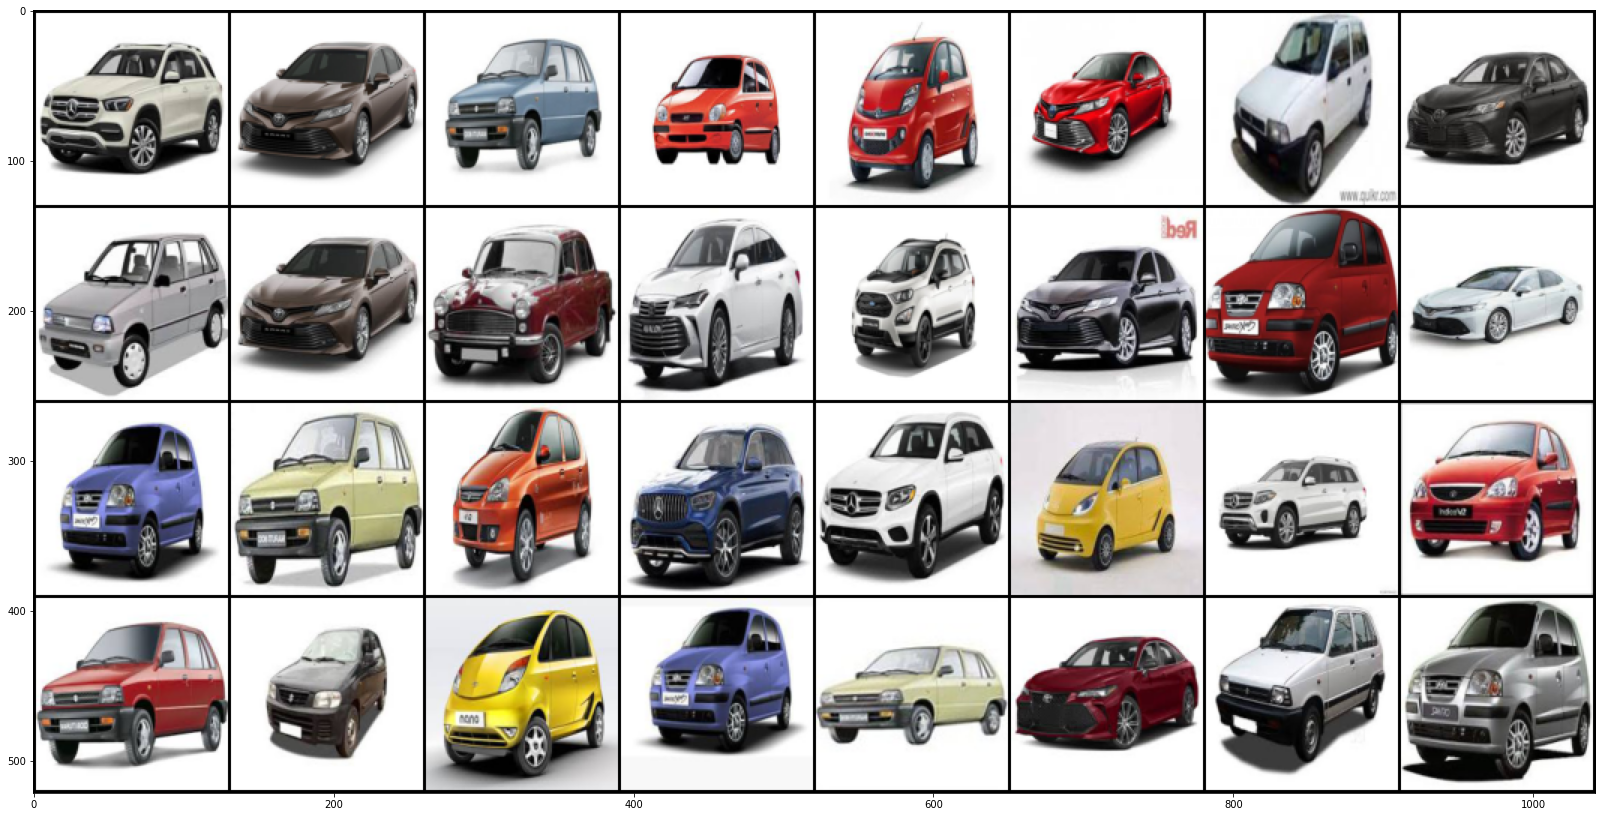

In [5]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(28,18))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))


In [6]:
images.shape

torch.Size([32, 3, 128, 128])

In [7]:
# # Download or load downloaded MNIST dataset
# # shuffle data at every epoch
# train_loader = torch.utils.data.DataLoader(
#     datasets.CIFAR10('data', train=True, download=True,
#                    transform=transforms.ToTensor()),
#     batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# # Same for test data
# test_loader = torch.utils.data.DataLoader(
#     datasets.CIFAR10('data', train=False, transform=transforms.ToTensor()),
#     batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [8]:
# 128//2

In [9]:
# channel_num = 3
# # kernel_num = 256
# image_size = 128
# latent_vector_dim = 256
# hidden_dims = [32, 64, 128, 256, 512]
# # hidden_dims[-1]*int((image_size/(2**len(hidden_dims)))**2)
# # hidden_dims[-1]
# # len(hidden_dims)
# # hidden_dims.reverse()
# hidden_dims
# # for i in range(len(hidden_dims) - 1):
# #   print(i)
# print(hidden_dims[-1]*int((image_size/(2**len(hidden_dims)))**2))
# int((image_size/(2**len(hidden_dims)))**2)
# hidden_dims[-1]

In [10]:
channel_num = 3
image_size = 128
latent_vector_dim = 256
num_samples = 16

sample_created = torch.randn(num_samples,latent_vector_dim)

class VAE_modified(nn.Module):
  def __init__(self):
    super(VAE_modified, self).__init__()
    # self.image_size = image_size
    # self.channel_num = channel_num
    # self.kernel_num = kernel_num

    
    self.hidden_dims = [64, 128, 256, 512, 1024]

    # Build Encoder
    modules = []
    in_channels = channel_num 
    for h_dim in self.hidden_dims:
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels=h_dim,
                          kernel_size= 3, stride= 2, padding  = 1),
                nn.BatchNorm2d(h_dim),
                nn.LeakyReLU())
        )
        in_channels = h_dim

    self.encoder = nn.Sequential(*modules)
    self.feature_volume = self.hidden_dims[-1]*int((image_size/(2**len(self.hidden_dims)))**2)
    # print(self.feature_volume)
    self.fc_mu = nn.Linear(self.feature_volume, latent_vector_dim)
    self.fc_var = nn.Linear(self.feature_volume, latent_vector_dim)
    

    # Build Decoder
    modules = []
    self.decoder_input = nn.Linear(latent_vector_dim, self.feature_volume)
    self.hidden_dims.reverse()
    for i in range(len(self.hidden_dims) - 1):
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(self.hidden_dims[i],
                                    self.hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=1,
                                    output_padding=1),
                nn.BatchNorm2d(self.hidden_dims[i + 1]),
                nn.LeakyReLU())
        )
    self.decoder = nn.Sequential(*modules)

    self.final_layer = nn.Sequential(
        nn.ConvTranspose2d(self.hidden_dims[-1],
                            self.hidden_dims[-1],
                            kernel_size=3,
                            stride=2,
                            padding=1,
                            output_padding=1),
        nn.BatchNorm2d(self.hidden_dims[-1]),
        nn.LeakyReLU(),
        nn.Conv2d(self.hidden_dims[-1], out_channels= 3,
                  kernel_size= 3, padding= 1),
        # nn.Tanh()
        nn.Sigmoid())
    

  def encode(self, x):
      """
      Encodes the input by passing through the encoder network
      and returns the latent codes.
      :param input: (Tensor) Input tensor to encoder [N x C x H x W]
      :return: (Tensor) List of latent codes
      """
      result = self.encoder(x)
      result = result.view(-1, self.feature_volume)

      # Split the result into mu and var components
      # of the latent Gaussian distribution
      mu = self.fc_mu(result)
      log_var = self.fc_var(result)

      return [mu, log_var]

  def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

  def decode(self, x):
    """
    Maps the given latent codes
    onto the image space.
    :param z: (Tensor) [B x D]
    :return: (Tensor) [B x C x H x W]
    """
    result = self.decoder_input(x)
    result = result.view(-1, self.hidden_dims[0],int(image_size/(2**len(self.hidden_dims))),int(image_size/(2**len(self.hidden_dims))))
    result = self.decoder(result)
    result = self.final_layer(result)
    return result

    
  def forward(self, x):
    # print(x.shape)
    mu, log_var = self.encode(x)
    # print(mu.shape, log_var.shape)
    z = self.reparameterize(mu, log_var)
    # print(z.shape)
    result = self.decode(z)
    # print(result.shape)
    return result, mu, log_var


  # def sample(self,num_samples):
  #       z = torch.randn(num_samples,
  #                       latent_vector_dim)

  #       z = z.cuda()

  #       samples = self.decode(z)
  #       return samples

  def sample(self):
        z = sample_created

        z = z.cuda()

        samples = self.decode(z)
        return samples

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = VAE_modified().to(device)
summary(model, input_size=(3, 128, 128))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         LeakyReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
         LeakyReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         295,168
       BatchNorm2d-8          [-1, 256, 16, 16]             512
         LeakyReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10            [-1, 512, 8, 8]       1,180,160
      BatchNorm2d-11            [-1, 512, 8, 8]           1,024
        LeakyReLU-12            [-1, 512, 8, 8]               0
           Conv2d-13           [-1, 1024, 4, 4]       4,719,616
      BatchNorm2d-14           [-1, 102

In [12]:
# class VAE(nn.Module):
#     def __init__(self):
#         super(VAE, self).__init__()

#         # ENCODER
#         # 28 x 28 pixels = 784 input pixels, 400 outputs
#         self.fc1 = nn.Linear(784, 400)
#         # rectified linear unit layer from 400 to 400
#         # max(0, x)
#         self.relu = nn.ReLU()
#         self.fc21 = nn.Linear(400, ZDIMS)  # mu layer
#         self.fc22 = nn.Linear(400, ZDIMS)  # logvariance layer
#         # this last layer bottlenecks through ZDIMS connections

#         # DECODER
#         # from bottleneck to hidden 400
#         self.fc3 = nn.Linear(ZDIMS, 400)
#         # from hidden 400 to 784 outputs
#         self.fc4 = nn.Linear(400, 784)
#         self.sigmoid = nn.Sigmoid()

#     def encode(self, x: Variable) -> (Variable, Variable):
#         """Input vector x -> fully connected 1 -> ReLU -> (fully connected
#         21, fully connected 22)

#         Parameters
#         ----------
#         x : [128, 784] matrix; 128 digits of 28x28 pixels each

#         Returns
#         -------

#         (mu, logvar) : ZDIMS mean units one for each latent dimension, ZDIMS
#             variance units one for each latent dimension

#         """

#         # h1 is [128, 400]
#         h1 = self.relu(self.fc1(x))  # type: Variable
#         return self.fc21(h1), self.fc22(h1)

#     def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
#         """THE REPARAMETERIZATION IDEA:

#         For each training sample (we get 128 batched at a time)

#         - take the current learned mu, stddev for each of the ZDIMS
#           dimensions and draw a random sample from that distribution
#         - the whole network is trained so that these randomly drawn
#           samples decode to output that looks like the input
#         - which will mean that the std, mu will be learned
#           *distributions* that correctly encode the inputs
#         - due to the additional KLD term (see loss_function() below)
#           the distribution will tend to unit Gaussians

#         Parameters
#         ----------
#         mu : [128, ZDIMS] mean matrix
#         logvar : [128, ZDIMS] variance matrix

#         Returns
#         -------

#         During training random sample from the learned ZDIMS-dimensional
#         normal distribution; during inference its mean.

#         """

#         if self.training:
#             # multiply log variance with 0.5, then in-place exponent
#             # yielding the standard deviation
#             std = logvar.mul(0.5).exp_()  # type: Variable
#             # - std.data is the [128,ZDIMS] tensor that is wrapped by std
#             # - so eps is [128,ZDIMS] with all elements drawn from a mean 0
#             #   and stddev 1 normal distribution that is 128 samples
#             #   of random ZDIMS-float vectors
#             eps = Variable(std.data.new(std.size()).normal_())
#             # - sample from a normal distribution with standard
#             #   deviation = std and mean = mu by multiplying mean 0
#             #   stddev 1 sample with desired std and mu, see
#             #   https://stats.stackexchange.com/a/16338
#             # - so we have 128 sets (the batch) of random ZDIMS-float
#             #   vectors sampled from normal distribution with learned
#             #   std and mu for the current input
#             return eps.mul(std).add_(mu)

#         else:
#             # During inference, we simply spit out the mean of the
#             # learned distribution for the current input.  We could
#             # use a random sample from the distribution, but mu of
#             # course has the highest probability.
#             return mu

#     def decode(self, z: Variable) -> Variable:
#         h3 = self.relu(self.fc3(z))
#         return self.sigmoid(self.fc4(h3))

#     def forward(self, x: Variable) -> (Variable, Variable, Variable):
#         mu, logvar = self.encode(x.view(-1, 784))
#         z = self.reparameterize(mu, logvar)
#         return self.decode(z), mu, logvar


In [13]:
# model = VAE()
model = VAE_modified()
if CUDA:
    model.cuda()

In [14]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    mse_loss = nn.MSELoss(size_average=False)
    # BCE = mse_loss(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # KLD = KLD/ x.size(0)

    return BCE + KLD, BCE, KLD

In [15]:
# # def loss_function(recon_x, x, mu, logvar) -> Variable:
# def loss_function(x_reconstructed, x, mean, logvar) -> Variable:
#     # how well do input x and output recon_x agree?
#     ####
#     # BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))
#     ####
#     BCE = nn.BCELoss(size_average=False)(x_reconstructed, x) / x.size(0)
#     # KLD is Kullback–Leibler divergence -- how much does one learned
#     # distribution deviate from another, in this specific case the
#     # learned distribution from the unit Gaussian

#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     # note the negative D_{KL} in appendix B of the paper
#     ####
#     # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     # # Normalise by same number of elements as in reconstruction
#     # KLD /= BATCH_SIZE * 784
#     ####
#     KLD = ((mean**2 + logvar.exp() - 1 - logvar) / 2).mean()

#     # BCE tries to make our reconstruction as accurate as possible
#     # KLD tries to push the distributions as close as possible to unit Gaussian
#     return BCE + KLD

In [16]:
# Dr Diederik Kingma: as if VAEs weren't enough, he also gave us Adam!

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.2)

In [17]:
len(data_loader.dataset)

512

In [18]:
def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    train_b = 0
    train_k = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(data_loader):
        # print(data.shape)
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        # loss = loss_function(recon_batch, data, mu, logvar)
        loss, b, k = loss_fn(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.item()
        train_b += b.item()
        train_k += k.item()
        optimizer.step()
        # if batch_idx % LOG_INTERVAL == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader),
        #         loss.item() / len(data)))
    if epoch % 50 == 0:
      print('====> Epoch: {} Average loss: {:.4f}, b : {:.4f}, k : {:.4f}'.format(
          epoch, train_loss / len(data_loader.dataset), train_b / len(data_loader.dataset), 
          train_k / len(data_loader.dataset)))


# def test(epoch):
#     # toggle model to test / inference mode
#     model.eval()
#     test_loss = 0

#     # each data is of BATCH_SIZE (default 128) samples
#     for i, (data, _) in enumerate(data_loader):
#         if CUDA:
#             # make sure this lives on the GPU
#             data = data.cuda()

#         # we're only going to infer, so no autograd at all required: volatile=True
#         data = Variable(data, volatile=True)
#         recon_batch, mu, logvar = model(data)
#         # test_loss += loss_function(recon_batch, data, mu, logvar).item()
#         test_loss += loss_fn(recon_batch, data, mu, logvar).item()
#         if i == 0:
#           n = min(data.size(0), 8)
#           # for the first 128 batch of the epoch, show the first 8 input digits
#           # with right below them the reconstructed output digits
#           comparison = torch.cat([data[:n],
#                                   recon_batch.view(BATCH_SIZE, 3, 128, 128)[:n]])
#           if epoch % 50 == 0:
#             save_image(comparison.data.cpu(),
#                       'reconstruction_' + str(epoch) + '.png', nrow=n, normalize = True)

#     test_loss /= len(data_loader.dataset)
#     if epoch % 50 == 0:
#       print('====> Test set loss: {:.4f}'.format(test_loss))


In [19]:
def test(epoch):
    model.eval()
    # test_loss = 0
    with torch.no_grad():
      # each data is of BATCH_SIZE (default 128) samples
      for i, (data, _) in enumerate(data_loader):
        if i == 0:
          if CUDA:
              # make sure this lives on the GPU
              data = data.cuda()

          # we're only going to infer, so no autograd at all required: volatile=True
          # data = Variable(data, volatile=True)
          ### add this ##
          n = 8
          dt = data[:n]
          recon_batch, mu, logvar = model(dt)
          comparison = torch.cat([dt, recon_batch])
          if epoch % 50 == 0:
              save_image(comparison.data.cpu(),
                        'reconstruction_' + str(epoch) + '.png', nrow=n)
              
              # nrow=n, normalize = True, range = (-1,1)


In [ ]:
# def sample(size):
#     z = Variable(
#         torch.randn(size, 128).cuda() if CUDA else
#         torch.randn(size, 128)
#     )
#     z_projected = self.project(z).view(
#         -1, kernel_num,
#         image_size // 8,
#         image_size // 8,
#     )
#     return self.decoder(z_projected).data

for epoch in range(1, EPOCHS + 1):
    current_lr = [g['lr'] for g in optimizer.param_groups]
    train(epoch)
    test(epoch)
    scheduler.step()

    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    # sample = Variable(torch.randn(64, ZDIMS))
    # sample = model.sample(64)
    # if CUDA:
    #     sample = sample.cuda()
    # sample = model.decoder(sample).cpu()
    # sample = model.sample(64)

    # save out as an 8x8 matrix of MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    if epoch % 50 == 0:
      sample = model.sample()
      print('LR: {}'.format(current_lr))
      save_image(sample.data.view(16, 3, 128, 128),
               'sample_' + str(epoch) + '.png')

In [ ]:
CUDA